In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import DataLoader, TensorDataset

from gru_seq2seq import GRUSeq2Seq
from lstm_seq2seq import LSTMSeq2Seq
from rnn_seq2seq import RNNSeq2Seq
from transformer import Transformer, Utils

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

2025-05-30 14:33:42.606173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 14:33:42.613521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748604822.622091   28751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748604822.624632   28751 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748604822.631384   28751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data = pd.read_csv('Reviews.csv', nrows=100000)

In [3]:
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                       "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                       "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                       "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [5]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [6]:
stop_words = set(stopwords.words('english'))


def text_cleaner(text):
    new_string = text.lower()
    new_string = BeautifulSoup(new_string, 'lxml').text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    new_string = re.sub('"', '', new_string)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    tokens = [w for w in new_string.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:
            long_words.append(i)
    return (" ".join(long_words)).strip()


cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [7]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [8]:
def summary_cleaner(text):
    new_string = re.sub('"', '', text)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    new_string = new_string.lower()
    tokens = new_string.split()
    new_string = ''
    for i in tokens:
        if len(i) > 1:
            new_string = new_string + i + ' '
    return new_string


cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [9]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_ ' + x + '_END_')
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: '_START_ ' + x + ' _END_')

In [11]:
len(data['cleaned_text']), len(data['cleaned_summary'])

(88350, 88350)

In [12]:
for i in range(5):
    print('Review: ', data['cleaned_text'][i])
    print('Summary: ', data['cleaned_summary'][i])
    print('\n')

Review:  _START_ bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better _END_
Summary:  _START_ good quality dog food _END_


Review:  _START_ product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo _END_
Summary:  _START_ not as advertised _END_


Review:  _START_ confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch _END_
Summary:  _START_ delight says it all _END_


Review:  _START_ looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal _END_
Summary:  _START_ cough medicine _END_


Review:  _START_ great 

In [13]:
data = data.reset_index()

In [14]:
data

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,_START_ bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better _END_,_START_ good quality dog food _END_
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",_START_ product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo _END_,_START_ not as advertised _END_
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",_START_ confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy tre...,_START_ delight says it all _END_
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,_START_ looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal _END_,_START_ cough medicine _END_
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",_START_ great taffy great price wide assortment yummy taffy delivery quick taffy lover deal _END_,_START_ great taffy _END_
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88345,99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!,_START_ love buy another box done last one _END_,_START_ yummy _END_
88346,99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu...",_START_ late father law used rating system meals particularly tasty would say tastes like exactly felt first time tried spicy picante ramyun ordered whim featured gold box deal would enjoyed ramen...,_START_ tastes like more _END_
88347,99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s...",_START_ favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack _END_,_START_ great ramen _END_
88348,99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra li...",_START_ like noodles although say spicy somewhat unde

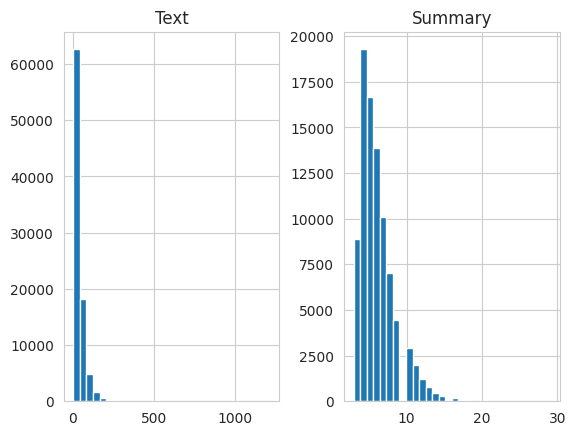

In [15]:
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text': text_word_count, 'Summary': summary_word_count})
length_df.hist(bins=30)
plt.show()

In [16]:
text_word_count = np.array(text_word_count)
summary_word_count = np.array(summary_word_count)
print(f'Text | Mean: {text_word_count.mean()} | Std: {text_word_count.std()} | Min: {text_word_count.min()} | Max: {text_word_count.max()}')
print(f'Summary | Mean: {summary_word_count.mean()} | Std: {summary_word_count.std()} | Min: {summary_word_count.min()} | Max: {summary_word_count.max()}')

Text | Mean: 40.46041878890775 | Std: 36.31676975625999 | Min: 4 | Max: 1214
Summary | Mean: 6.013050367855121 | Std: 2.4854800821068084 | Min: 3 | Max: 29


In [17]:
max_len_text = 100
max_len_summary = 10

In [18]:
data[['cleaned_text', 'cleaned_summary']]

,cleaned_text,cleaned_summary
0,_START_ bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better _END_,_START_ good quality dog food _END_
1,_START_ product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo _END_,_START_ not as advertised _END_
2,_START_ confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy tre...,_START_ delight says it all _END_
3,_START_ looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal _END_,_START_ cough medicine _END_
4,_START_ great taffy great price wide assortment yummy taffy delivery quick taffy lover deal _END_,_START_ great taffy _END_
...,...,...
88345,_START_ love buy another box done last one _END_,_START_ yummy _END_
88346,_START_ late father law used rating system meals particularly tasty would say tastes like exactly felt first time tried spicy picante ramyun ordered whim featured gold box deal would enjoyed ramen...,_START_ tastes like more _END_
88347,_START_ favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack _END_,_START_ great ramen _END_
88348,_START_ like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually dra...,_START_ spicy _END_


In [19]:
reduced_data = data[data['cleaned_text'].str.split().str.len() <= max_len_text]
reduced_data = reduced_data[reduced_data['cleaned_summary'].str.split().str.len() <= max_len_summary]
reduced_data

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,_START_ bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better _END_,_START_ good quality dog food _END_
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",_START_ product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo _END_,_START_ not as advertised _END_
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",_START_ confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy tre...,_START_ delight says it all _END_
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,_START_ looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal _END_,_START_ cough medicine _END_
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",_START_ great taffy great price wide assortment yummy taffy delivery quick taffy lover deal _END_,_START_ great taffy _END_
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88344,99994,99995,B000LQORDE,AL22WN8RBBOW7,"LifeInTheCity ""trogg""",2,5,5,1256428800,Good Stuff,I love these noodle. A little to spicy for the wife but perfct for me.,_START_ love noodle little spicy wife perfct _END_,_START_ good stuff _END_
88345,99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!,_START_ love buy another box done last one _END_,_START_ yummy _END_
88346,99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu...",_START_ late father law used rating system meals particularly tasty would say tastes like exactly felt first time tried spicy picante ramyun ordered whim featured gold box deal would enjoyed ramen...,_START_ tastes like more _END_
88347,99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s...",_START_ favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack _END_,_START_ great ramen _END_


In [20]:
x_tr, x_val, y_tr, y_val = train_test_split(reduced_data['cleaned_text'], reduced_data['cleaned_summary'], test_size=0.1,
                                            random_state=0, shuffle=True)

In [21]:
x_tr.index, y_tr.index

(Index([34613, 71147, 32344, 25319, 65515, 38981, 88308, 47549, 85139, 82569,
        ...
        58456, 43855, 53888, 61166, 46551, 23642, 50867, 47249, 48301, 76073],
       dtype='int64', length=71259),
 Index([34613, 71147, 32344, 25319, 65515, 38981, 88308, 47549, 85139, 82569,
        ...
        58456, 43855, 53888, 61166, 46551, 23642, 50867, 47249, 48301, 76073],
       dtype='int64', length=71259))

In [22]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

In [23]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

In [24]:
y_tokenizer.index_word[5]

'the'

In [25]:
y_tr

array([[   1,   11,   34, ...,    0,    0,    0],
       [   1, 1459,  856, ...,    0,    0,    0],
       [   1,  572,  220, ...,  225,    2,    0],
       ...,
       [   1,   27,    9, ...,    0,    0,    0],
       [   1,    8,   73, ...,    0,    0,    0],
       [   1,    3,   71, ...,    0,    0,    0]], dtype=int32)

In [75]:
train_data = TensorDataset(torch.from_numpy(x_tr).long(), torch.from_numpy(y_tr).long())
val_data = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)

In [27]:
def accuracy(outputs, targets):
    flattened_outputs = outputs.argmax(dim=-1).flatten()
    flattened_targets = targets[:, 1:].flatten()
    accuracies = flattened_outputs.eq(flattened_targets)
    mask = torch.logical_not(flattened_outputs.eq(0))
    accuracies = torch.logical_and(mask, accuracies)
    return (accuracies.sum() / mask.sum()).item()

In [28]:
def train_and_validate(model_, optimizer_, criterion_, train_loader_, val_loader_, epochs_, device_, model_type='rnn'):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs_):
        model_.train()
        total_train_loss = 0
        for (inputs, targets) in train_loader_:
            inputs, targets = inputs.to(device_), targets.to(device_)
            outputs = model_(inputs, targets[:, :-1])
            loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
            total_train_loss += loss.item()
            optimizer_.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_.parameters(), 1.0)
            optimizer_.step()

        model_.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for (inputs, targets) in val_loader_:
                inputs, targets = inputs.to(device_), targets.to(device_)
                if model_type == 'transformer':
                    outputs = model_(inputs, targets[:, :-1])
                else:
                    outputs = model_(inputs, targets[:, :-1], 0)
                loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), targets[:, 1:].flatten())
                total_val_loss += loss.item()
                total_val_acc += accuracy(outputs, targets)

        total_train_loss = total_train_loss / len(train_loader_)
        total_val_loss = total_val_loss / len(val_loader_)
        total_val_acc = total_val_acc / len(val_loader_)

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)
        val_accs.append(total_val_acc)
        print(
            f'Epoch: {epoch + 1} / {epochs_} | Train loss: {total_train_loss} | Val loss: {total_val_loss} | Val acc: {total_val_acc}')
    return train_losses, val_losses, val_accs


In [29]:
def plot_losses(model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [30]:
target_word_index = y_tokenizer.word_index
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word

In [31]:
def decode_sequence(input_seq, model_, rnn_type='rnn'):
    model_.eval()
    with torch.no_grad():
        if rnn_type == 'lstm':
            enc_output, hidden, cell_state = model_.encoder(torch.IntTensor(input_seq).to(device))
        else:
            enc_output, hidden = model_.encoder(torch.IntTensor(input_seq).to(device))
    
        target_seq = torch.zeros(1, dtype=torch.int64).to(device)
        target_seq[0] = target_word_index['start']
    
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            if rnn_type == 'lstm':
                prediction, hidden, _ = model_.decoder(target_seq, enc_output, hidden, cell_state)
            else:
                prediction, hidden = model_.decoder(target_seq, enc_output, hidden)
            prediction_index = prediction.argmax(dim=-1)[0].item()
            predicted_word = reverse_target_word_index[prediction_index]
    
            if predicted_word != 'end':
                decoded_sentence += ' ' + predicted_word
    
            if predicted_word == 'end' or len(decoded_sentence.split()) >= max_len_summary - 1:
                stop_condition = True
    
            target_seq = torch.zeros(1, dtype=torch.int64).to(device)
            target_seq[0] = prediction_index
    
        return decoded_sentence


In [32]:
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
        if (i != 0 and i != target_word_index['start']) and i != target_word_index['end']:
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string


# RNN Seq2Seq

In [33]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [34]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 5.78255431992667 | Val loss: 5.469281911849976 | Val acc: 0.12214542413130403
Epoch: 2 / 10 | Train loss: 5.526162212235587 | Val loss: 5.459406107664108 | Val acc: 0.12220788514241576
Epoch: 3 / 10 | Train loss: 5.457312648636954 | Val loss: 5.475294500589371 | Val acc: 0.12211419409140944
Epoch: 4 / 10 | Train loss: 5.428636387416295 | Val loss: 5.462756097316742 | Val acc: 0.12216104008257389
Epoch: 5 / 10 | Train loss: 5.367075511387417 | Val loss: 5.465065032243729 | Val acc: 0.1220048894174397
Epoch: 6 / 10 | Train loss: 5.332634234428406 | Val loss: 5.465446352958679 | Val acc: 0.12187997018918395
Epoch: 7 / 10 | Train loss: 5.304453934941973 | Val loss: 5.46784633398056 | Val acc: 0.1220361185260117
Epoch: 8 / 10 | Train loss: 5.261818824495588 | Val loss: 5.483280301094055 | Val acc: 0.12191120069473982
Epoch: 9 / 10 | Train loss: 5.245754078456334 | Val loss: 5.529431909322739 | Val acc: 0.12225472927093506
Epoch: 10 / 10

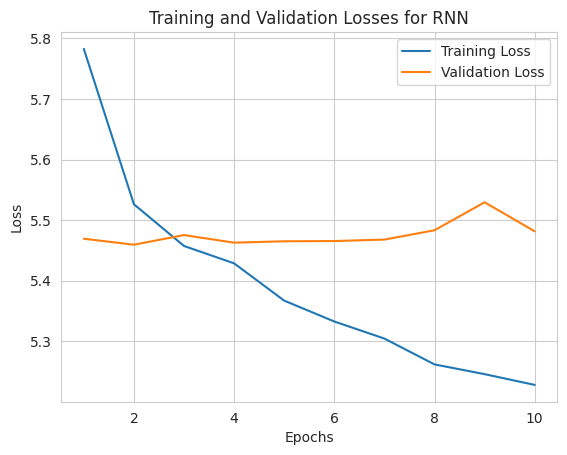

In [35]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [36]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great


# RNN Seq2Seq With Attention

In [37]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [38]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 5.745921312059675 | Val loss: 5.456003487110138 | Val acc: 0.12206734949722886
Epoch: 2 / 10 | Train loss: 5.519576552936009 | Val loss: 5.447171658277512 | Val acc: 0.12186435423791409
Epoch: 3 / 10 | Train loss: 5.418209297316415 | Val loss: 5.365699499845505 | Val acc: 0.12154168309643865
Epoch: 4 / 10 | Train loss: 5.249141849790301 | Val loss: 5.28247344493866 | Val acc: 0.12292389292269945
Epoch: 5 / 10 | Train loss: 5.120085488046919 | Val loss: 5.190268695354462 | Val acc: 0.12421606108546257
Epoch: 6 / 10 | Train loss: 4.994033425194877 | Val loss: 5.145455151796341 | Val acc: 0.12362793507054448
Epoch: 7 / 10 | Train loss: 4.858292760167803 | Val loss: 5.101897448301315 | Val acc: 0.1242687189951539
Epoch: 8 / 10 | Train loss: 4.741607672827584 | Val loss: 5.076484650373459 | Val acc: 0.1249563479796052
Epoch: 9 / 10 | Train loss: 4.643611689976283 | Val loss: 5.048025846481323 | Val acc: 0.12445985851809382
Epoch: 10 / 1

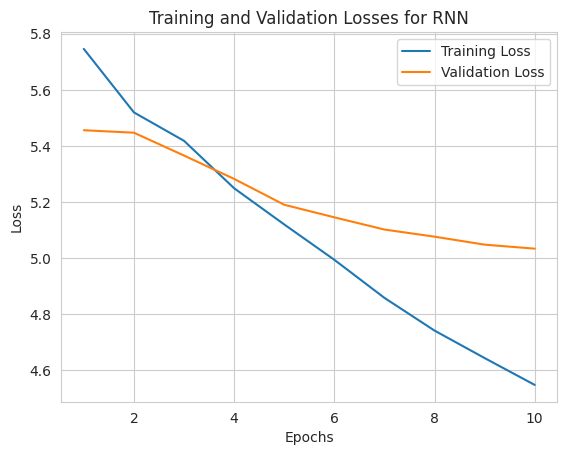

In [39]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [40]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great popcorn


# RNN Seq2Seq With Attention and BiDirectional Encoder

In [41]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [42]:
print('RNNSeq2Seq Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

RNNSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 5.759944418498448 | Val loss: 5.45758992433548 | Val acc: 0.12205173401162028
Epoch: 2 / 10 | Train loss: 5.530748976979937 | Val loss: 5.424539715051651 | Val acc: 0.1219736598432064
Epoch: 3 / 10 | Train loss: 5.359778336116245 | Val loss: 5.230713129043579 | Val acc: 0.12421982223168015
Epoch: 4 / 10 | Train loss: 5.13455479826246 | Val loss: 5.0956085324287415 | Val acc: 0.12537555675953627
Epoch: 5 / 10 | Train loss: 4.942108086177281 | Val loss: 5.008881747722626 | Val acc: 0.12659626174718142
Epoch: 6 / 10 | Train loss: 4.74485547542572 | Val loss: 4.953882694244385 | Val acc: 0.1273261746391654
Epoch: 7 / 10 | Train loss: 4.585215932982308 | Val loss: 4.9344914853572845 | Val acc: 0.12632419541478157
Epoch: 8 / 10 | Train loss: 4.408898898533413 | Val loss: 4.8966653645038605 | Val acc: 0.1273138653486967
Epoch: 9 / 10 | Train loss: 4.25297931262425 | Val loss: 4.922308653593063 | Val acc: 0.12636363180354238
Epoch: 10 / 10

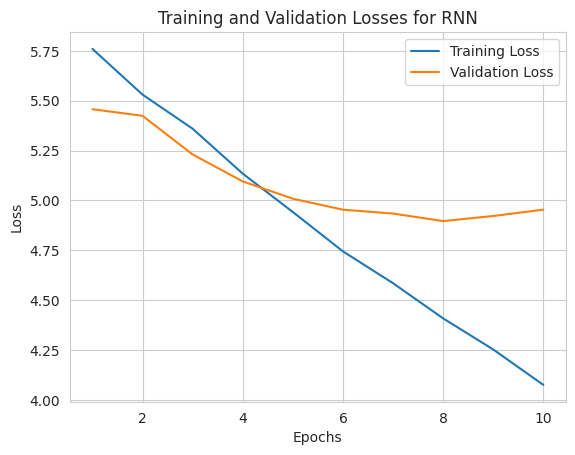

In [43]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

In [44]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great popcorn


# LSTM Seq2Seq

In [50]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [51]:
print('LSTMSeq2Seq Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

LSTMSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 6.400410570417132 | Val loss: 5.410135179758072 | Val acc: 0.12202050443738699
Epoch: 2 / 10 | Train loss: 5.492473173141479 | Val loss: 5.391184598207474 | Val acc: 0.12197365937754512
Epoch: 3 / 10 | Train loss: 5.436134723254613 | Val loss: 5.393121749162674 | Val acc: 0.12203611945733428
Epoch: 4 / 10 | Train loss: 5.400390519414629 | Val loss: 5.387248277664185 | Val acc: 0.1220205039717257
Epoch: 5 / 10 | Train loss: 5.366744562557765 | Val loss: 5.386561304330826 | Val acc: 0.12206734856590629
Epoch: 6 / 10 | Train loss: 5.348261213302612 | Val loss: 5.381038308143616 | Val acc: 0.12195804389193654
Epoch: 7 / 10 | Train loss: 5.322901480538505 | Val loss: 5.3919177651405334 | Val acc: 0.12213926902040839
Epoch: 8 / 10 | Train loss: 5.282323152678353 | Val loss: 5.3833969831466675 | Val acc: 0.12215078063309193
Epoch: 9 / 10 | Train loss: 5.241410616465977 | Val loss: 5.3906384110450745 | Val acc: 0.12211088836193085
Epoch: 

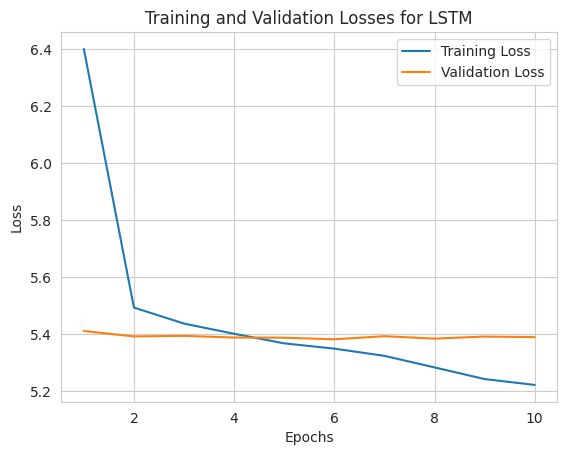

In [52]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

In [53]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, rnn_type='lstm'))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great


# LSTM Seq2Seq With Attention

In [54]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [55]:
print('LSTMSeq2Seq Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

LSTMSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 6.1537390777042935 | Val loss: 5.412853002548218 | Val acc: 0.12194242933765054
Epoch: 2 / 10 | Train loss: 5.47398943901062 | Val loss: 5.384585022926331 | Val acc: 0.12226213794201612
Epoch: 3 / 10 | Train loss: 5.422789175169808 | Val loss: 5.388170212507248 | Val acc: 0.12197160767391324
Epoch: 4 / 10 | Train loss: 5.383300420216152 | Val loss: 5.375735580921173 | Val acc: 0.12223295960575342
Epoch: 5 / 10 | Train loss: 5.343223432132176 | Val loss: 5.370975971221924 | Val acc: 0.12206450011581182
Epoch: 6 / 10 | Train loss: 5.28203295639583 | Val loss: 5.327404707670212 | Val acc: 0.12306613754481077
Epoch: 7 / 10 | Train loss: 5.193006093161447 | Val loss: 5.268360495567322 | Val acc: 0.12345696706324816
Epoch: 8 / 10 | Train loss: 5.105946506772723 | Val loss: 5.227414965629578 | Val acc: 0.12439739890396595
Epoch: 9 / 10 | Train loss: 5.012731535094125 | Val loss: 5.207829535007477 | Val acc: 0.12381086824461818
Epoch: 10 

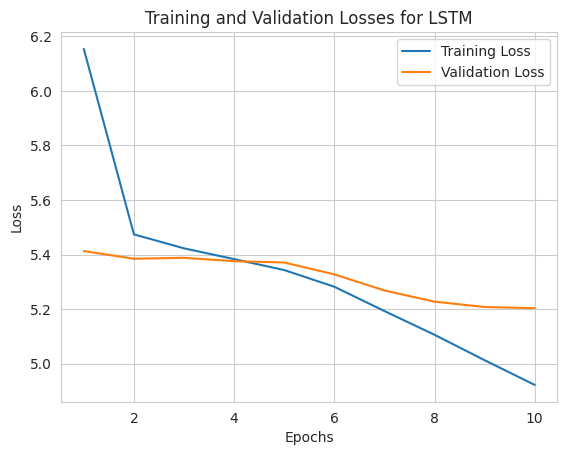

In [56]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

In [57]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, 'lstm'))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great


# LSTM Seq2Seq With Attention and BiDirectional Encoder

In [58]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [59]:
print('LSTMSeq2Seq Start Training:')
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

LSTMSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 6.10033083643232 | Val loss: 5.413976550102234 | Val acc: 0.12205378524959087
Epoch: 2 / 10 | Train loss: 5.486262052399772 | Val loss: 5.388089567422867 | Val acc: 0.12204968323931098
Epoch: 3 / 10 | Train loss: 5.433105635643005 | Val loss: 5.372571796178818 | Val acc: 0.1220340677537024
Epoch: 4 / 10 | Train loss: 5.390601461274283 | Val loss: 5.357751250267029 | Val acc: 0.12225393205881119
Epoch: 5 / 10 | Train loss: 5.30722918169839 | Val loss: 5.3043016493320465 | Val acc: 0.12335381796583533
Epoch: 6 / 10 | Train loss: 5.21559567792075 | Val loss: 5.259382635354996 | Val acc: 0.1232568216510117
Epoch: 7 / 10 | Train loss: 5.117054581642151 | Val loss: 5.2217116355896 | Val acc: 0.12355111353099346
Epoch: 8 / 10 | Train loss: 5.031202738625662 | Val loss: 5.194064944982529 | Val acc: 0.1241059573367238
Epoch: 9 / 10 | Train loss: 4.924704074859619 | Val loss: 5.189961820840836 | Val acc: 0.12386797228828073
Epoch: 10 / 10 |

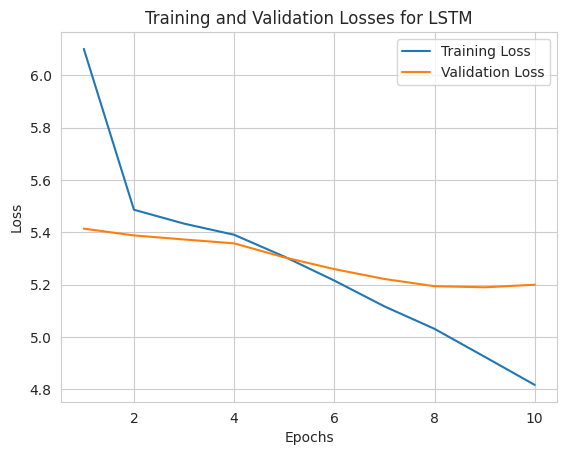

In [60]:
plot_losses('LSTM', lstm_train_losses, lstm_val_losses, epochs)

In [61]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, 'lstm'))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great


# GRU Seq2Seq

In [63]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [64]:
print('GRUSeq2Seq Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRUSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 5.711017417907715 | Val loss: 5.305397570133209 | Val acc: 0.12372493045404553
Epoch: 2 / 10 | Train loss: 5.264680882862636 | Val loss: 5.130396753549576 | Val acc: 0.12546104192733765
Epoch: 3 / 10 | Train loss: 5.023152991703578 | Val loss: 5.0335904359817505 | Val acc: 0.1252181543968618
Epoch: 4 / 10 | Train loss: 4.801872846058437 | Val loss: 4.954943090677261 | Val acc: 0.12609441624954343
Epoch: 5 / 10 | Train loss: 4.566464604650225 | Val loss: 4.9375859797000885 | Val acc: 0.12540063308551908
Epoch: 6 / 10 | Train loss: 4.3334012167794365 | Val loss: 4.96597558259964 | Val acc: 0.12411952065303922
Epoch: 7 / 10 | Train loss: 4.094708119119916 | Val loss: 5.03686785697937 | Val acc: 0.12110925046727061
Epoch: 8 / 10 | Train loss: 3.8575166889599393 | Val loss: 5.140838444232941 | Val acc: 0.12026877794414759
Epoch: 9 / 10 | Train loss: 3.587763489995684 | Val loss: 5.30442351102829 | Val acc: 0.11514638364315033
Epoch: 10 

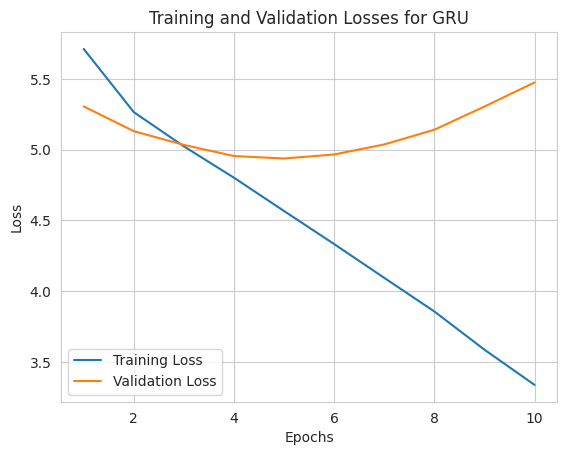

In [65]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

In [66]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, rnn_type='gru'))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great popcorn popcorn


# GRU Seq2Seq With Attention

In [67]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [68]:
print('GRUSeq2Seq Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRUSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 5.699107193946839 | Val loss: 5.287706941366196 | Val acc: 0.12540598819032311
Epoch: 2 / 10 | Train loss: 5.224365745271955 | Val loss: 5.073332250118256 | Val acc: 0.12619220884516835
Epoch: 3 / 10 | Train loss: 4.929001270021711 | Val loss: 4.926406383514404 | Val acc: 0.12707918416708708
Epoch: 4 / 10 | Train loss: 4.673541695731027 | Val loss: 4.874302059412003 | Val acc: 0.12813427858054638
Epoch: 5 / 10 | Train loss: 4.423537758418492 | Val loss: 4.8594871163368225 | Val acc: 0.12601634208112955
Epoch: 6 / 10 | Train loss: 4.152772121770042 | Val loss: 4.892521560192108 | Val acc: 0.1256846645846963
Epoch: 7 / 10 | Train loss: 3.889962043081011 | Val loss: 4.955537706613541 | Val acc: 0.12336943252012134
Epoch: 8 / 10 | Train loss: 3.5582361936569216 | Val loss: 5.0775492787361145 | Val acc: 0.12000366533175111
Epoch: 9 / 10 | Train loss: 3.2687686681747437 | Val loss: 5.200219571590424 | Val acc: 0.11260957783088088
Epoch: 

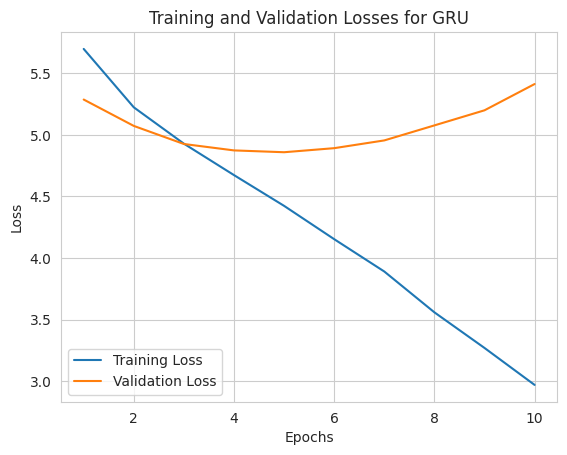

In [69]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

In [70]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model, 'gru'))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   best popcorn


# GRU Seq2Seq With Attention and BiDirectional Encoder

In [71]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUSeq2Seq(embedding_dim, hidden_dim, enc_layers, dec_layers, enc_vocab_size, dec_vocab_size, attention=True, encoder_modes='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [72]:
print('GRUSeq2Seq Start Training:')
gru_train_losses, gru_val_losses, gru_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device)

GRUSeq2Seq Start Training:
Epoch: 1 / 10 | Train loss: 5.755894902774266 | Val loss: 5.434788882732391 | Val acc: 0.12209857907146215
Epoch: 2 / 10 | Train loss: 5.456667944363185 | Val loss: 5.288819283246994 | Val acc: 0.12304391292855144
Epoch: 3 / 10 | Train loss: 5.250741938182286 | Val loss: 5.144938141107559 | Val acc: 0.12518977280706167
Epoch: 4 / 10 | Train loss: 5.023391209329877 | Val loss: 5.017102152109146 | Val acc: 0.12629250809550285
Epoch: 5 / 10 | Train loss: 4.791238651956831 | Val loss: 4.932515263557434 | Val acc: 0.12719179596751928
Epoch: 6 / 10 | Train loss: 4.582245574678693 | Val loss: 4.880279511213303 | Val acc: 0.12633935594931245
Epoch: 7 / 10 | Train loss: 4.347327055249895 | Val loss: 4.887166053056717 | Val acc: 0.12581824837252498
Epoch: 8 / 10 | Train loss: 4.092859751837594 | Val loss: 4.941044420003891 | Val acc: 0.12385691609233618
Epoch: 9 / 10 | Train loss: 3.8125469054494587 | Val loss: 5.017619878053665 | Val acc: 0.12027447763830423
Epoch: 10

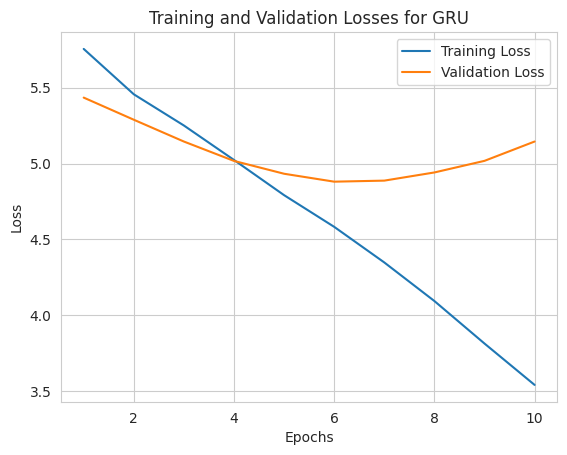

In [73]:
plot_losses('GRU', gru_train_losses, gru_val_losses, epochs)

In [74]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
Predicted summary:   great popcorn popcorn


# Transformer

In [76]:
def decode_sequence(input_seq, model_):
    model_.eval()
    with torch.no_grad():
        input_seq = torch.IntTensor(input_seq).to(device)
        target_seq = torch.zeros((1,1), dtype=torch.int64).to(device)
        target_seq[0] = target_word_index['start']
    
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            trg_mask = Utils.make_combined_mask(target_seq)
            prediction = model_(input_seq, target_seq, look_ahead_mask=trg_mask)
            print(prediction.argmax(dim=-1))
            prediction_index = prediction[:, -1:, :].argmax(dim=-1)[0].item()
            predicted_word = reverse_target_word_index[prediction_index]
    
            if predicted_word != 'end':
                decoded_sentence += ' ' + predicted_word
    
            if predicted_word == 'end' or len(decoded_sentence.split()) >= max_len_summary - 1:
                stop_condition = True
    
            target_seq = torch.zeros((1, 1), dtype=torch.int64).to(device)
            target_seq[0] = prediction_index
    
        return decoded_sentence

In [77]:
epochs = 10
embedding_dim = 400
hidden_dim = 512
enc_layers = 1
dec_layers = 1
enc_vocab_size = x_voc_size
dec_vocab_size = y_voc_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(enc_vocab_size=enc_vocab_size, 
                    dec_vocab_size=dec_vocab_size, 
                    enc_len_seq=max_len_text, 
                    dec_len_seq=max_len_summary - 1, 
                    embedding_dim=embedding_dim, 
                    enc_depth=enc_layers, 
                    dec_depth=dec_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [78]:
print('Transformer Start Training:')
transformer_train_losses, transformer_val_losses, transformer_val_accs = train_and_validate(model, optimizer, criterion, train_loader,
                                                                    val_loader, epochs, device, model_type='transformer')

Transformer Start Training:
Epoch: 1 / 10 | Train loss: 1.9015001943017251 | Val loss: 0.2962221234075485 | Val acc: 0.4798351473385288
Epoch: 2 / 10 | Train loss: 0.2203443624761417 | Val loss: 0.08754551119261211 | Val acc: 0.49305963083620996
Epoch: 3 / 10 | Train loss: 0.018063836671659454 | Val loss: 0.05755095161317337 | Val acc: 0.49445589655830013
Epoch: 4 / 10 | Train loss: 0.001850357044156293 | Val loss: 0.04624995777022935 | Val acc: 0.4950070285028027
Epoch: 5 / 10 | Train loss: 0.0007819181811432329 | Val loss: 0.03856654370564126 | Val acc: 0.4955617179793696
Epoch: 6 / 10 | Train loss: 0.0004846401133489272 | Val loss: 0.035475239946296616 | Val acc: 0.49567906894991476
Epoch: 7 / 10 | Train loss: 0.00030929976693355385 | Val loss: 0.03318026637838733 | Val acc: 0.495899774855183
Epoch: 8 / 10 | Train loss: 0.00022309875708592544 | Val loss: 0.03130969702596626 | Val acc: 0.4959789442439233
Epoch: 9 / 10 | Train loss: 0.0001652685107269928 | Val loss: 0.0296120295045717

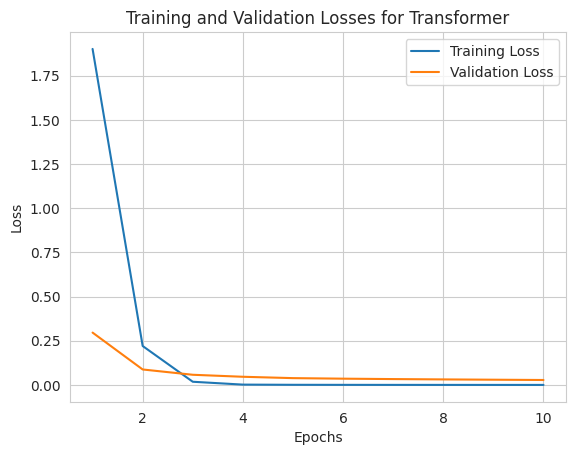

In [79]:
plot_losses('Transformer', transformer_train_losses, transformer_val_losses, epochs)

In [80]:
for i in range(len(x_val)):
    print('Review: ', seq2text(x_val[i]))
    print('Original summary: ', seq2summary(y_val[i]))
    print('Predicted summary: ', decode_sequence(x_val[i].reshape(1, max_len_text), model))
    print('\n')
    if i == 0:
        break

Review:  start family loves popcorn amish country popcorn wonderful tender tasty delightful love nearly hull less kernels tiny size popped product good enjoy watching movies even curling reading good book end 
Original summary:  to die for 
tensor([[   1,    1,    1,    1,    1,    1, 4745, 5525,    2]],
       device='cuda:0')
Predicted summary:  




In [81]:
reverse_target_word_index[4745], reverse_target_word_index[5525]

('candycane', 'satay')